In [1]:
import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class DrivingDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None):
        self.images_dir = images_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"frame_{self.data.iloc[idx, 0]:05d}.png")
        image = Image.open(img_name).convert('RGB')
        control = self.data.iloc[idx, 1:].values.astype('float32')  # [steering, throttle, brake]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(control, dtype=torch.float32)

In [ ]:
import torch.nn as nn

class DrivingModel(nn.Module):
    def __init__(self):
        super(DrivingModel, self).__init__()
        
        # CNN Layers (input: 3x224x224)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),  # Output: 24x110x110
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), # Output: 36x53x53
            nn.ReLU(),
            nn.Conv2d(36, 64, kernel_size=3, stride=1), # Output: 64x51x51
            nn.ReLU(),
            nn.Flatten()                                # Output: 64*51*51 = 166464
        )
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(166464, 100),
            nn.ReLU(),
            nn.Linear(100, 3)  # Output: [steering, throttle, brake]
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [3]:
class DrivingDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None):
        self.images_dir = images_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.valid_indices = [idx for idx in range(len(self.data)) 
                             if os.path.exists(self._get_image_path(idx))]

    def _get_image_path(self, idx):
        return os.path.join(self.images_dir, f"frame_{self.data.iloc[idx, 0]:05d}.png")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = self._get_image_path(actual_idx)
        
        try:
            image = Image.open(img_path).convert('RGB')
            control = self.data.iloc[actual_idx, 1:].values.astype('float32')
            
            if self.transform:
                image = self.transform(image)
                
            return image, torch.tensor(control, dtype=torch.float32)
        
        except Exception as e:
            print(f"Skipping corrupted/missing file {img_path}: {e}")
            return None, None

Epoch [1/10], Loss: 0.1569
Epoch [2/10], Loss: 0.0614
Epoch [3/10], Loss: 0.0433
Epoch [4/10], Loss: 0.0323
Epoch [5/10], Loss: 0.0240
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0155
Epoch [8/10], Loss: 0.0129
Epoch [9/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0096


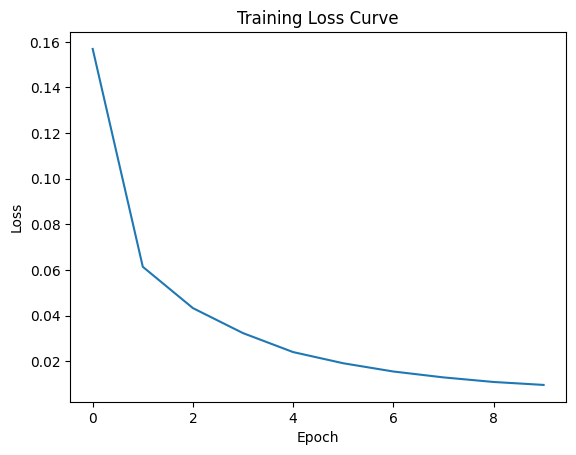

Model saved as 'driving_model.pth'


In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 16
epochs = 10
learning_rate = 0.001

# Paths (update these!)
images_dir = r'C:\Users\TANMAY\OneDrive\Desktop\Major project self driving\New\dataset\images'
csv_file = r'C:\Users\TANMAY\OneDrive\Desktop\Major project self driving\New\dataset\controls.csv'

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize Dataset and DataLoader
train_dataset = DrivingDataset(images_dir, csv_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DrivingModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
train_loss = []
for epoch in range(epochs):
    epoch_loss = 0.0
    for images, controls in train_loader:
        images, controls = images.to(device), controls.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, controls)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Plot Training Curve
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Save Model
torch.save(model.state_dict(), 'driving_model.pth')
print("Model saved as 'driving_model.pth'")

In [5]:
# Load Saved Model
model = DrivingModel().to(device)
model.load_state_dict(torch.load('driving_model.pth'))
model.eval()

# Example Inference
def predict_controls(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        controls = model(image)
    return controls.cpu().numpy()  # [steering, throttle, brake]

# Test on a sample image
sample_image = os.path.join(images_dir, 'frame_00000.png')
predicted_controls = predict_controls(sample_image)
print(f"Predicted Controls: {predicted_controls}")

Predicted Controls: [[-0.36049765  0.7770216   0.05437278]]
